In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
import time
warnings.filterwarnings("ignore")

In [8]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/xgboost/enc_data_multi.csv')
esc = pd.read_csv('../../data/regional_datasets/xgboost/esc_data_multi.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/xgboost/mid_atlantic_data_multi.csv')
mountain = pd.read_csv('../../data/regional_datasets/xgboost/mountain_data_multi.csv')
new_england = pd.read_csv('../../data/regional_datasets/xgboost/new_england_data_multi.csv')
pacific = pd.read_csv('../../data/regional_datasets/xgboost/pacific_data_multi.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/xgboost/south_atlantic_data_multi.csv')
wnc = pd.read_csv('../../data/regional_datasets/xgboost/wnc_data_multi.csv')
wsc = pd.read_csv('../../data/regional_datasets/xgboost/wsc_data_multi.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(np.int64)


In [28]:
def train_baseline_model(df, feature_perc=0.95, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.15)
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    train = df.iloc[:-size]
    test = df.iloc[-size:]

    X_train = train.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_train = train[features]
    y_train = train['new_confirmed']
    # y_train_log = np.log(y_train)
    # y_train_log.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    X_test = test.drop(columns=['new_confirmed', 'region', 'location_key'])
    # X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1, early_stopping_rounds=10,)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(actual, y_pred_gb)
    mse = mean_squared_error(actual, y_pred_gb)
    rmse = mean_squared_error(actual, y_pred_gb, squared=False)
    mase = mean_absolute_scaled_error(actual, y_pred_gb, y_train=y_train_gb)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region}')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()

    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    stats = stats.sort_values('importance', ascending=False)  
    stats = stats.sort_values('importance', ascending=False)
    stats["cum_importance"] = np.cumsum(stats['importance'])

    n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    important_features = stats[:n_percent] 
    print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    print(f"Important features: {list(important_features.index)}")

In [29]:
start_time = time.time()
for df in datasets:
    train_baseline_model(df, plot=False)
    print("\n")
    
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
MAE: 3983.72
MSE: 34522933.71
RMSE: 5875.62
MASE: 0.47
Number of features for 95.0% importance: 33, out of 62
Important features: ['7_day_shift', '7_day_avg', 'dayofyear', 'new_deceased', 'cumulative_persons_vaccinated', '2_day_shift', 'average_temperature_celsius', 'cumulative_persons_fully_vaccinated_pfizer', '1_day_shift', 'cumulative_deceased', 'new_persons_fully_vaccinated_janssen', 'cumulative_persons_fully_vaccinated_moderna', 'cumulative_persons_fully_vaccinated_janssen', 'school_closing', 'international_travel_controls', 'income_support', 'new_hospitalized_patients', 'location_key_US_OH', 'relative_humidity', 'cumulative_vaccine_doses_administered_moderna', 'new_persons_fully_vaccinated_pfizer', 'new_vaccine_doses_administered', 'cumulative_confirmed', 'day', 'weekofyear', 'new_persons_vaccinated', 'cumulative_hospitalized_patients', 'minimum_temperature_celsius', 'current_hospitalized_patients', 'month', 'workplace_closing', 'stay_at_h

## Feature Selection

In [7]:
# first_fs = {
#     "East North Central": {
#         "features": ['7_day_shift', '7_day_avg', 'dayofyear', 'new_deceased', '1_day_shift', 'cumulative_persons_vaccinated', 'average_temperature_celsius', 'new_persons_fully_vaccinated_janssen', '2_day_shift', 'location_key_US_OH', 'school_closing', 'international_travel_controls', 'current_hospitalized_patients', 'new_hospitalized_patients', 'cumulative_vaccine_doses_administered', 'relative_humidity', 'cumulative_persons_fully_vaccinated_moderna', 'cancel_public_events', 'new_vaccine_doses_administered_pfizer', 'new_persons_vaccinated', 'rainfall_mm', 'cumulative_hospitalized_patients', 'cumulative_vaccine_doses_administered_moderna', 'new_persons_fully_vaccinated_moderna', 'cumulative_confirmed', 'dew_point', 'weekofyear', 'public_transport_closing', 'minimum_temperature_celsius', 'new_vaccine_doses_administered', 'day', 'maximum_temperature_celsius'],
#     },
#     "East South Central": {
#         "features": ['7_day_shift', '7_day_avg', '1_day_shift', 'new_deceased', '2_day_shift', 'location_key_US_AL', 'day', 'month', 'facial_coverings', 'cumulative_persons_fully_vaccinated', '3_day_shift', 'dayofyear', 'new_hospitalized_patients', 'new_vaccine_doses_administered_moderna', 'school_closing', 'current_hospitalized_patients', 'current_intensive_care_patients', 'new_persons_fully_vaccinated', 'restrictions_on_gatherings', 'minimum_temperature_celsius', 'weekofyear', 'cumulative_deceased', 'cumulative_vaccine_doses_administered_pfizer', 'cumulative_persons_fully_vaccinated_janssen', 'cumulative_hospitalized_patients', 'stringency_index', 'workplace_closing', 'new_vaccine_doses_administered', 'average_temperature_celsius', 'new_persons_vaccinated', 'dew_point', 'relative_humidity', 'cumulative_vaccine_doses_administered', 'maximum_temperature_celsius'],
#     },
#     "Mid-Atlantic": {
#         "features": ['7_day_avg', 'new_hospitalized_patients', 'cumulative_confirmed', '1_day_shift', 'location_key_US_PA', 'new_persons_fully_vaccinated_janssen', 'year', '2_day_shift', 'stay_at_home_requirements', 'workplace_closing', 'month', 'rainfall_mm', 'location_key_US_NY', 'new_deceased', 'current_hospitalized_patients', 'international_travel_controls', 'cumulative_persons_fully_vaccinated', 'cumulative_persons_vaccinated', 'cumulative_persons_fully_vaccinated_janssen', 'testing_policy', 'cumulative_hospitalized_patients', 'minimum_temperature_celsius', 'cumulative_deceased', 'new_persons_vaccinated', '9_day_shift', 'dayofyear'],
#     },
#     "Mountain": {
#         "features": ['7_day_avg', '7_day_shift', '6_day_shift', '1_day_shift', 'current_hospitalized_patients', 'location_key_US_CO', 'new_deceased', 'dayofyear', 'cumulative_persons_fully_vaccinated_pfizer', 'new_persons_fully_vaccinated_pfizer', 'dew_point', 'cumulative_confirmed', 'public_transport_closing', 'average_temperature_celsius', 'relative_humidity', 'day', 'current_intensive_care_patients', 'new_persons_vaccinated', 'minimum_temperature_celsius', 'new_vaccine_doses_administered_moderna', 'location_key_US_ID', 'location_key_US_NV', 'cumulative_deceased', 'cumulative_vaccine_doses_administered_moderna', 'new_persons_fully_vaccinated_moderna', 'new_vaccine_doses_administered_janssen', 'weekofyear', 'new_vaccine_doses_administered_pfizer', 'debt_relief', 'new_hospitalized_patients', 'cancel_public_events', 'new_persons_fully_vaccinated', 'stringency_index', 'cumulative_vaccine_doses_administered', 'month', 'new_vaccine_doses_administered'],
#     },
#     "New England": {
#         "features": ['7_day_shift', 'new_persons_fully_vaccinated_pfizer', '7_day_avg', 'minimum_temperature_celsius', 'year', 'rainfall_mm', '1_day_shift', 'public_transport_closing', 'dayofyear', 'new_deceased', 'relative_humidity', 'new_vaccine_doses_administered_pfizer', 'dew_point', 'current_intensive_care_patients', 'new_hospitalized_patients', 'school_closing', 'day', 'cumulative_confirmed', 'month', 'new_persons_fully_vaccinated_janssen', 'cumulative_deceased', 'new_persons_vaccinated', 'cumulative_hospitalized_patients', 'current_hospitalized_patients', 'new_vaccine_doses_administered_moderna', 'average_temperature_celsius'],
#     },
#     "Pacific": {
#         "features": ['7_day_avg', 'cumulative_persons_vaccinated', '7_day_shift', 'new_vaccine_doses_administered', '3_day_shift', 'relative_humidity', 'vaccination_policy', 'cumulative_vaccine_doses_administered', 'dew_point', 'cumulative_vaccine_doses_administered_janssen', 'maximum_temperature_celsius', '1_day_shift', 'new_persons_fully_vaccinated_moderna', 'new_deceased', '10_day_shift', 'cumulative_confirmed', 'current_hospitalized_patients', 'new_vaccine_doses_administered_janssen', 'average_temperature_celsius'],
#     },
#     "South Atlantic": {
#         "features": ['7_day_avg', '7_day_shift', 'new_vaccine_doses_administered', 'new_deceased', '1_day_shift', 'minimum_temperature_celsius', 'maximum_temperature_celsius', 'cumulative_hospitalized_patients', 'stay_at_home_requirements', 'cumulative_confirmed', 'current_intensive_care_patients', 'cumulative_persons_fully_vaccinated', 'rainfall_mm', 'new_persons_fully_vaccinated_moderna', 'new_vaccine_doses_administered_moderna', 'month', 'current_hospitalized_patients', 'new_persons_vaccinated', 'cumulative_vaccine_doses_administered_moderna', 'location_key_US_MD', 'dayofyear', 'new_persons_fully_vaccinated_janssen', '6_day_shift', 'school_closing', 'cumulative_deceased', 'dew_point', 'new_persons_fully_vaccinated', 'workplace_closing', 'new_persons_fully_vaccinated_pfizer', 'weekofyear', 'cancel_public_events', 'cumulative_persons_fully_vaccinated_moderna', 'day', 'relative_humidity', 'new_vaccine_doses_administered_janssen', 'new_vaccine_doses_administered_pfizer'],
#     },
#     "West North Central": {
#         "features": ['7_day_shift', 'relative_humidity', 'new_persons_fully_vaccinated', 'dayofyear', 'new_persons_fully_vaccinated_pfizer', '7_day_avg', 'new_persons_vaccinated', 'average_temperature_celsius', 'cumulative_hospitalized_patients', 'cumulative_persons_fully_vaccinated', 'new_vaccine_doses_administered', 'new_vaccine_doses_administered_moderna', 'new_hospitalized_patients', 'new_deceased', 'current_intensive_care_patients', 'location_key_US_IA', '6_day_shift', 'international_travel_controls', 'school_closing', 'debt_relief', 'current_hospitalized_patients', '1_day_shift', 'day', 'new_persons_fully_vaccinated_janssen', 'facial_coverings', 'cancel_public_events', 'weekofyear', 'location_key_US_KS', 'maximum_temperature_celsius', 'minimum_temperature_celsius', 'cumulative_confirmed', 'cumulative_persons_vaccinated', 'location_key_US_MN', 'cumulative_deceased'],
#     },
#     "West South Central": {
#         "features": ['7_day_avg', 'cumulative_deceased', 'cumulative_confirmed', 'new_persons_fully_vaccinated', '7_day_shift', 'cumulative_hospitalized_patients', 'cumulative_persons_vaccinated', 'new_vaccine_doses_administered', 'day', 'new_vaccine_doses_administered_pfizer', 'new_hospitalized_patients', 'stringency_index', 'maximum_temperature_celsius', 'new_vaccine_doses_administered_moderna', 'rainfall_mm', '1_day_shift', 'cancel_public_events', 'new_persons_fully_vaccinated_janssen', 'new_vaccine_doses_administered_janssen', 'current_intensive_care_patients', 'cumulative_persons_fully_vaccinated', 'dayofyear', 'new_deceased', 'new_persons_vaccinated'],
#     }

# }

In [30]:
first_fs = {
    "East North Central": {
        "features": ['7_day_shift', '7_day_avg', 'dayofyear', 'new_deceased', 'cumulative_persons_vaccinated', '2_day_shift', 'average_temperature_celsius', 'cumulative_persons_fully_vaccinated_pfizer', '1_day_shift', 'cumulative_deceased', 'new_persons_fully_vaccinated_janssen', 'cumulative_persons_fully_vaccinated_moderna', 'cumulative_persons_fully_vaccinated_janssen', 'school_closing', 'international_travel_controls', 'income_support', 'new_hospitalized_patients', 'location_key_US_OH', 'relative_humidity', 'cumulative_vaccine_doses_administered_moderna', 'new_persons_fully_vaccinated_pfizer', 'new_vaccine_doses_administered', 'cumulative_confirmed', 'day', 'weekofyear', 'new_persons_vaccinated', 'cumulative_hospitalized_patients', 'minimum_temperature_celsius', 'current_hospitalized_patients', 'month', 'workplace_closing', 'stay_at_home_requirements', 'rainfall_mm'],
    },
    "East South Central": {
        "features": ['7_day_shift', '7_day_avg', '1_day_shift', 'new_deceased', '2_day_shift', 'cumulative_persons_fully_vaccinated', 'location_key_US_AL', 'facial_coverings', 'day', 'international_travel_controls', '3_day_shift', 'dayofyear', 'current_hospitalized_patients', 'new_vaccine_doses_administered_janssen', 'new_hospitalized_patients', 'minimum_temperature_celsius', 'new_vaccine_doses_administered_moderna', 'restrictions_on_gatherings', 'month', 'school_closing', 'current_intensive_care_patients', 'cumulative_vaccine_doses_administered_janssen', 'cumulative_hospitalized_patients', 'new_persons_fully_vaccinated', 'relative_humidity', 'average_temperature_celsius', 'new_vaccine_doses_administered_pfizer', 'new_persons_vaccinated', 'stringency_index', 'new_vaccine_doses_administered', 'cumulative_deceased', 'new_persons_fully_vaccinated_pfizer', 'weekofyear', 'income_support'],
    },
    "Mid-Atlantic": {
        "features": ['7_day_avg', 'cumulative_persons_vaccinated', 'cumulative_deceased', '1_day_shift', 'new_persons_fully_vaccinated_janssen', 'month', 'location_key_US_PA', 'new_deceased', 'minimum_temperature_celsius', 'stringency_index', 'year', 'current_hospitalized_patients', 'rainfall_mm', 'dew_point', 'cumulative_persons_fully_vaccinated_pfizer', 'new_persons_vaccinated', 'day', 'cancel_public_events', 'weekofyear', 'school_closing', 'workplace_closing', 'new_hospitalized_patients', 'current_intensive_care_patients', '9_day_shift', '8_day_shift'],
    },
    "Mountain": {
        "features": ['7_day_avg', '7_day_shift', 'cumulative_vaccine_doses_administered_pfizer', '6_day_shift', '1_day_shift', 'current_hospitalized_patients', 'month', 'new_deceased', 'average_temperature_celsius', 'dayofyear', 'location_key_US_ID', 'cumulative_persons_vaccinated', 'location_key_US_CO', 'weekofyear', 'public_transport_closing', 'minimum_temperature_celsius', 'new_persons_vaccinated', 'stay_at_home_requirements', 'day', 'location_key_US_NV', 'relative_humidity', 'dew_point', 'current_intensive_care_patients', 'cumulative_deceased', 'new_vaccine_doses_administered_pfizer', 'new_vaccine_doses_administered_janssen', 'debt_relief', 'contact_tracing', 'new_hospitalized_patients', 'stringency_index', 'workplace_closing', 'cumulative_vaccine_doses_administered_moderna', 'new_persons_fully_vaccinated_pfizer', 'cumulative_confirmed', 'cumulative_persons_fully_vaccinated_pfizer', 'cumulative_persons_fully_vaccinated_janssen', 'cumulative_persons_fully_vaccinated_moderna', 'maximum_temperature_celsius'],
    },
    "New England": {
        "features": ['7_day_shift', 'minimum_temperature_celsius', '7_day_avg', '1_day_shift', 'rainfall_mm', 'relative_humidity', 'new_deceased', 'cumulative_confirmed', 'public_transport_closing', 'new_persons_fully_vaccinated_pfizer', 'new_hospitalized_patients', 'dayofyear', 'maximum_temperature_celsius', 'new_vaccine_doses_administered_moderna', 'day', 'cumulative_deceased', 'cancel_public_events'],
    },
    "Pacific": {
       "features": ['7_day_avg', 'cumulative_persons_vaccinated', 'current_intensive_care_patients', 'dew_point', '7_day_shift', 'cumulative_vaccine_doses_administered_moderna', '3_day_shift', 'new_deceased', 'cumulative_deceased', 'new_persons_fully_vaccinated', '10_day_shift', '1_day_shift', 'new_vaccine_doses_administered', 'new_persons_fully_vaccinated_pfizer', 'cumulative_persons_fully_vaccinated_janssen', 'cumulative_confirmed', 'current_hospitalized_patients', 'maximum_temperature_celsius'], 
    }, 
    "South Atlantic": {
        "features": ['7_day_avg', 'new_vaccine_doses_administered_pfizer', '7_day_shift', 'new_vaccine_doses_administered', 'new_deceased', '1_day_shift', 'new_vaccine_doses_administered_janssen', 'dew_point', 'cumulative_deceased', 'maximum_temperature_celsius', 'dayofyear', 'cumulative_vaccine_doses_administered', 'relative_humidity', 'current_intensive_care_patients', 'new_persons_vaccinated', 'location_key_US_MD', 'new_persons_fully_vaccinated_pfizer', 'new_vaccine_doses_administered_moderna', 'new_persons_fully_vaccinated_moderna', '6_day_shift', 'rainfall_mm', 'new_hospitalized_patients', 'average_temperature_celsius', 'public_transport_closing', 'cumulative_vaccine_doses_administered_moderna', 'day', 'new_persons_fully_vaccinated', 'cumulative_confirmed', 'current_hospitalized_patients', 'weekofyear', 'cumulative_persons_fully_vaccinated_moderna', 'minimum_temperature_celsius', 'stringency_index'],
    },
    "West North Central": {
        "features": ['7_day_shift', 'relative_humidity', 'new_persons_fully_vaccinated_janssen', 'new_vaccine_doses_administered_pfizer', 'dayofyear', 'new_persons_fully_vaccinated_pfizer', 'new_persons_fully_vaccinated', '7_day_avg', 'new_persons_vaccinated', 'average_temperature_celsius', 'cancel_public_events', 'cumulative_hospitalized_patients', 'cumulative_persons_fully_vaccinated_moderna', 'new_vaccine_doses_administered', 'cumulative_confirmed', 'rainfall_mm', 'location_key_US_KS', 'new_deceased', 'new_hospitalized_patients', 'cumulative_persons_fully_vaccinated_janssen', 'current_intensive_care_patients', 'cumulative_persons_fully_vaccinated', 'day', 'location_key_US_IA', 'income_support', 'facial_coverings', '1_day_shift', 'new_persons_fully_vaccinated_moderna', 'minimum_temperature_celsius', 'international_travel_controls', 'school_closing', 'weekofyear', '6_day_shift', 'current_hospitalized_patients', 'cumulative_deceased', 'cumulative_persons_vaccinated'],
    },
    "West South Central": {
        "features": ['7_day_avg', 'dayofyear', '7_day_shift', 'current_hospitalized_patients', 'cumulative_hospitalized_patients', 'cumulative_persons_fully_vaccinated_pfizer', 'day', 'cumulative_vaccine_doses_administered', 'new_vaccine_doses_administered', 'current_intensive_care_patients', 'maximum_temperature_celsius', 'new_hospitalized_patients', 'workplace_closing', 'stringency_index', 'average_temperature_celsius', '1_day_shift', 'new_deceased', 'new_vaccine_doses_administered_moderna', 'rainfall_mm', 'cumulative_persons_vaccinated', 'cumulative_deceased', 'cumulative_confirmed', 'new_persons_fully_vaccinated', 'cumulative_persons_fully_vaccinated', 'dew_point', 'new_vaccine_doses_administered_pfizer'],
    }
}

In [31]:
def train_model_with_features(df, features, feature_perc=0.95, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.15)
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    train = df.iloc[:-size]
    test = df.iloc[-size:]

    X_train = train[features]
    y_train = train['new_confirmed']

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping_rounds=10)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
    

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(actual, y_pred_gb)
    mse = mean_squared_error(actual, y_pred_gb)
    rmse = mean_squared_error(actual, y_pred_gb, squared=False)
    mase = mean_absolute_scaled_error(actual, y_pred_gb, y_train=y_train_gb)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions for {region}')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()

    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X_train.columns)
    stats = stats.sort_values('importance', ascending=False)  
    stats = stats.sort_values('importance', ascending=False)
    stats["cum_importance"] = np.cumsum(stats['importance'])

    n_percent = np.where(stats["cum_importance"] > feature_perc)[0][0] + 1

    important_features = stats[:n_percent] 
    print(f"Number of features for {feature_perc * 100}% importance: {n_percent}, out of {len(stats)}")
    print(f"Important features: {list(important_features.index)}")


In [32]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    features = first_fs[region]["features"]
    train_model_with_features(df, features, plot=False)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
MAE: 3965.47
MSE: 35432467.12
RMSE: 5952.52
MASE: 0.46
Number of features for 95.0% importance: 24, out of 33
Important features: ['7_day_shift', 'new_deceased', '7_day_avg', 'dayofyear', '2_day_shift', 'average_temperature_celsius', 'cumulative_persons_vaccinated', '1_day_shift', 'cumulative_persons_fully_vaccinated_janssen', 'cumulative_persons_fully_vaccinated_moderna', 'new_persons_fully_vaccinated_janssen', 'international_travel_controls', 'location_key_US_OH', 'income_support', 'new_hospitalized_patients', 'cumulative_persons_fully_vaccinated_pfizer', 'cumulative_confirmed', 'new_persons_vaccinated', 'relative_humidity', 'cumulative_vaccine_doses_administered_moderna', 'minimum_temperature_celsius', 'cumulative_hospitalized_patients', 'new_persons_fully_vaccinated_pfizer', 'weekofyear']


Training model for East South Central...
MAE: 1448.78
MSE: 6303329.24
RMSE: 2510.64
MASE: 0.4
Number of features for 95.0% importance: 24, out of 34
Impo

## Parameter Tuning

In [44]:
def parameter_tune(df, features=None):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.2)
    if 'date' in df.columns:
        df.set_index('date', inplace=True)
    train = df.iloc[:-size]
    test = df.iloc[-size:]

    if features:
        X_train = train[features]
        X_test = test[features]
    else:
        X_train = train.drop(columns=['new_confirmed', 'region', 'location_key'])
        X_test = test.drop(columns=['new_confirmed', 'region', 'location_key'])
    
    y_train = train['new_confirmed']
    y_test = test['new_confirmed']

    # fit model
    results_df = pd.DataFrame(columns=['Learning Rate', 'N Estimators', 'Depth', 'MAE', 'RMSE', 'MASE'])
    max_depths =  [2, 3, 5, 8, None]
    # learning_rates = [0.01, 0.05, 0.1, 0.15]
    learning_rates = [0.05, 0.1, 0.25, 0.5]
    # n_estimators = [250, 500, 1000]
    n_estimators = [25, 50, 100, 250, 500]
    # subsample = [0.7, 0.8, 0.9]
    for lr in learning_rates:
        for n_est in n_estimators:
            for depth in max_depths:
                if depth == None:
                    model = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, early_stopping_rounds=10, n_jobs=-1)
                else:
                    model = xgb.XGBRegressor(n_estimators=n_est, learning_rate=lr, max_depth=depth, early_stopping_rounds=10, n_jobs=-1)
                
                model.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)], 
                        verbose=False)
                

                # make predictions
                y_pred = model.predict(X_test)

                actual = y_test.groupby(y_test.index).sum()
                y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
                y_train_gb = y_train.groupby(y_train.index).sum()

                # calculate metrics
                mae = mean_absolute_error(y_test, y_pred)
                # mse = mean_squared_error(actual, y_pred_gb)
                rmse = mean_squared_error(y_test, y_pred, squared=False)
                mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

                results_df = results_df.append({'Learning Rate': lr, 'N Estimators': n_est, 'Depth': depth,
                                            'MAE': mae, 'RMSE': rmse, 'MASE': mase}, 
                                        ignore_index=True)
    results_df = results_df.sort_values('MASE')
    print(results_df.head())

In [45]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    # features = baseline_fs[region]["features"]
    parameter_tune(df)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
    Learning Rate  N Estimators  Depth          MAE         RMSE      MASE
16           0.05         250.0    3.0  1218.796350  2055.258256  0.514441
21           0.05         500.0    3.0  1218.796350  2055.258256  0.514441
11           0.05         100.0    3.0  1218.796350  2055.258256  0.514441
46           0.10         500.0    3.0  1243.226958  2070.730124  0.524753
26           0.10          25.0    3.0  1243.226958  2070.730124  0.524753


Training model for East South Central...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
22           0.05         500.0    5.0  884.726962  1838.171980  0.648635
12           0.05         100.0    5.0  884.726962  1838.171980  0.648635
17           0.05         250.0    5.0  884.726962  1838.171980  0.648635
7            0.05          50.0    5.0  884.726962  1838.171980  0.648635
27           0.10          25.0    5.0  893.372400  1847.358504  0.654973


Training model for M

In [46]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    features = first_fs[region]["features"]
    parameter_tune(df, features)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
    Learning Rate  N Estimators  Depth          MAE         RMSE      MASE
11           0.05         100.0    3.0  1179.124956  2029.817620  0.497696
16           0.05         250.0    3.0  1179.124956  2029.817620  0.497696
21           0.05         500.0    3.0  1179.124956  2029.817620  0.497696
31           0.10          50.0    3.0  1189.448518  2077.550529  0.502054
36           0.10         100.0    3.0  1189.448518  2077.550529  0.502054


Training model for East South Central...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
42            0.1         250.0    5.0  850.886859  1723.434915  0.623825
27            0.1          25.0    5.0  850.886859  1723.434915  0.623825
32            0.1          50.0    5.0  850.886859  1723.434915  0.623825
37            0.1         100.0    5.0  850.886859  1723.434915  0.623825
47            0.1         500.0    5.0  850.886859  1723.434915  0.623825


Training model for M

In [43]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    features = first_fs[region]["features"]
    parameter_tune(df, features)
    print("\n")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
    Learning Rate  N Estimators  Depth          MAE         RMSE      MASE
57           0.25         500.0    4.0  1097.010623  1879.995811  0.463037
53           0.25         250.0    4.0  1097.010623  1879.995811  0.463037
49           0.25         100.0    4.0  1097.010623  1879.995811  0.463037
45           0.25          50.0    4.0  1097.010623  1879.995811  0.463037
41           0.25          25.0    4.0  1097.010623  1879.995811  0.463037


Training model for East South Central...
    Learning Rate  N Estimators  Depth         MAE         RMSE      MASE
49           0.25         100.0    4.0  836.056756  1816.917984  0.612953
57           0.25         500.0    4.0  836.056756  1816.917984  0.612953
41           0.25          25.0    4.0  836.056756  1816.917984  0.612953
45           0.25          50.0    4.0  836.056756  1816.917984  0.612953
53           0.25         250.0    4.0  836.056756  1816.917984  0.612953


Training model for M

# Final Model

In [50]:
# final 2
parameters = {
    "East North Central": {
        "features": first_fs["East North Central"]["features"],
        "learning_rate": 0.25,
        "n_estimators": 500,
        "depth": 4,
    },
    "East South Central": {
        "features": first_fs["East South Central"]["features"],
        "learning_rate": 0.25,
        "n_estimators": 100,
        "depth": 4,
    },
    "Mid-Atlantic": {
        "features": first_fs["Mid-Atlantic"]["features"],
        "learning_rate": 0.25,
        "n_estimators": 100,
        "depth": 3,
    },
    "Mountain": {
        "features": first_fs["Mountain"]["features"],
        "learning_rate": 0.25,
        "n_estimators": 25,
        "depth": 2,
    },
    "New England": {
        "features": first_fs["New England"]["features"],
        "learning_rate": 0.25,
        "n_estimators": 100,
        "depth": None,
    },
    "Pacific": {
        "features": first_fs["Pacific"]["features"],
        "learning_rate": 0.25,
        "n_estimators": 100,
        "depth": 8,
    },
    "South Atlantic": {
        "features": first_fs["South Atlantic"]["features"],
        "learning_rate": 0.1,
        "n_estimators": 500,
        "depth": None,
    },
    "West North Central": {
        "features": first_fs["West North Central"]["features"],
        "learning_rate": 0.25,
        "n_estimators": 500,
        "depth": None,
    },
    "West South Central": {
        "features": first_fs["West South Central"]["features"],
        "learning_rate": 0.5,
        "n_estimators": 25,
        "depth": 4,
    }

}

In [51]:
def final_model(df, params, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    features = params["features"]
    if features is None:
        features = df.drop(columns=['new_confirmed', 'region', 'location_key']).columns
    n_estimators = params["n_estimators"]
    learning_rate = params["learning_rate"]
    depth = params["depth"]

    size = round(df.shape[0]*0.2)
    df.sort_values('date', inplace=True)
    train = df.iloc[:-size]
    test = df.iloc[-size:]

    X_train = train[features]
    y_train = train['new_confirmed']

    X_test = test[features]
    y_test = test['new_confirmed']

    # fit model
    if depth == None:
        model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, early_stopping_rounds=10)
    else:
        model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=depth, early_stopping_rounds=10)

    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)], 
            verbose=False)
    print(f"Model Params: n_estimators={params['n_estimators']}, learning_rate={params['learning_rate']}, max_depth={params['depth']}, early_stopping_rounds=10")
    

    # make predictions
    y_pred = model.predict(X_test)

    actual = y_test.groupby(y_test.index).sum()
    y_pred_gb = pd.Series(y_pred, index=y_test.index).groupby(y_test.index).sum()
    y_train_gb = y_train.groupby(y_train.index).sum()

    # calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'XGBoost Predictions on Test Data for {region}')
        plt.xlabel('Date')
        plt.ylabel('New Confirmed Cases')
        plt.plot(actual.index, actual, label='Actual')
        plt.plot(actual.index, y_pred_gb, label='Predicted')
        plt.legend() 
        plt.show()
        

Training model for East North Central...
Model Params: n_estimators=500, learning_rate=0.25, max_depth=4, early_stopping_rounds=10
MAE: 1097.01
MSE: 3534384.25
RMSE: 1880.0
MASE: 0.47


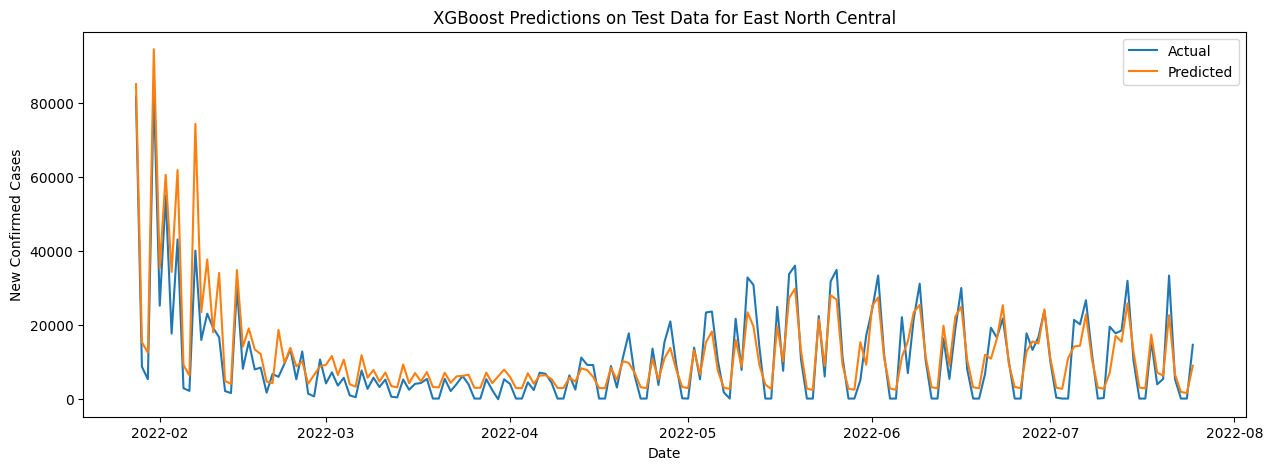


Training model for East South Central...
Model Params: n_estimators=100, learning_rate=0.25, max_depth=4, early_stopping_rounds=10
MAE: 836.06
MSE: 3301190.96
RMSE: 1816.92
MASE: 0.63


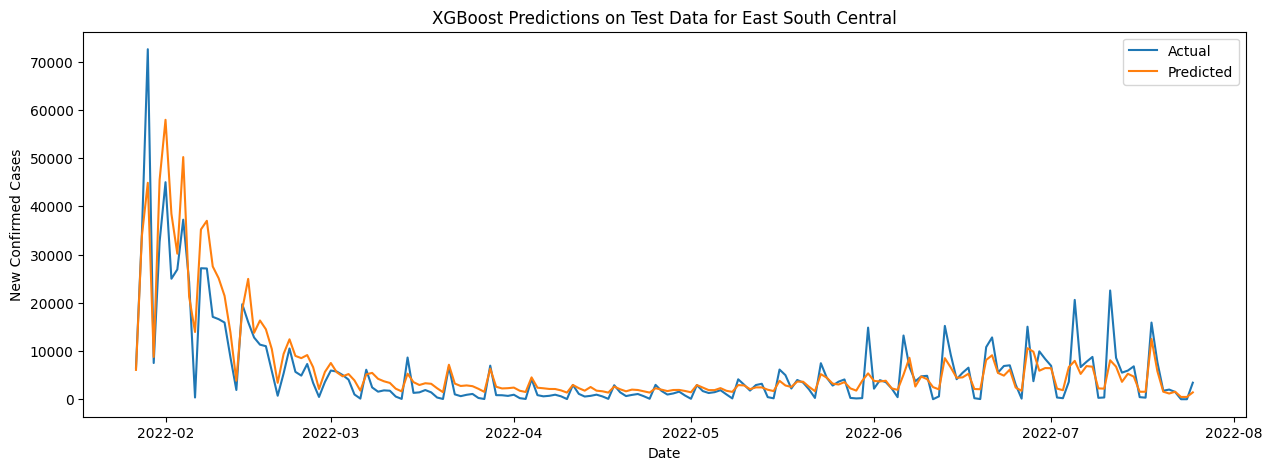


Training model for Mid-Atlantic...
Model Params: n_estimators=100, learning_rate=0.25, max_depth=3, early_stopping_rounds=10
MAE: 1809.37
MSE: 8819562.63
RMSE: 2969.77
MASE: 0.71


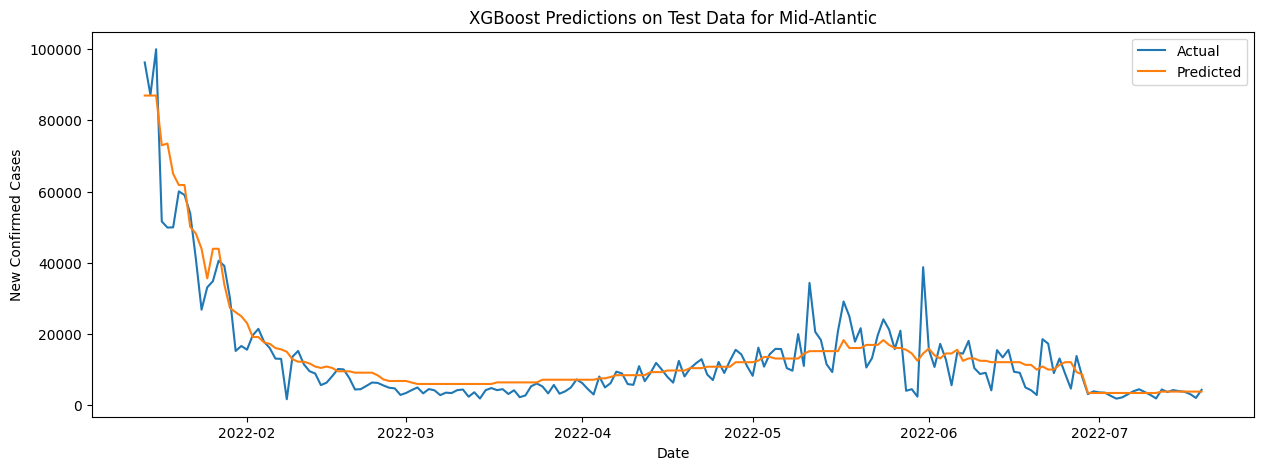


Training model for Mountain...
Model Params: n_estimators=25, learning_rate=0.25, max_depth=2, early_stopping_rounds=10
MAE: 759.64
MSE: 2670352.68
RMSE: 1634.12
MASE: 0.73


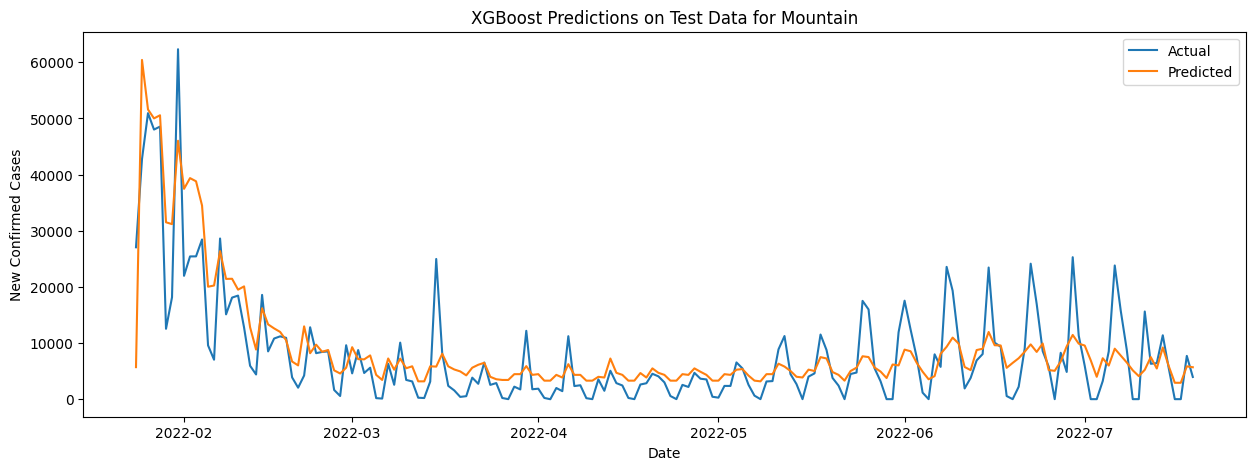


Training model for New England...
Model Params: n_estimators=100, learning_rate=0.25, max_depth=None, early_stopping_rounds=10
MAE: 361.22
MSE: 968464.47
RMSE: 984.11
MASE: 0.38


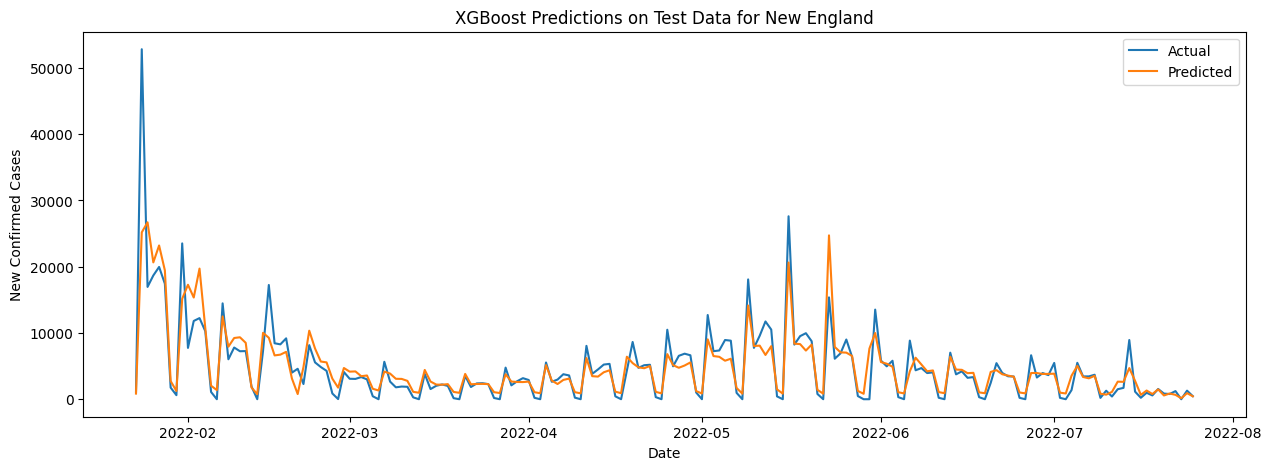


Training model for Pacific...
Model Params: n_estimators=100, learning_rate=0.25, max_depth=8, early_stopping_rounds=10
MAE: 3093.9
MSE: 41381210.07
RMSE: 6432.82
MASE: 0.69


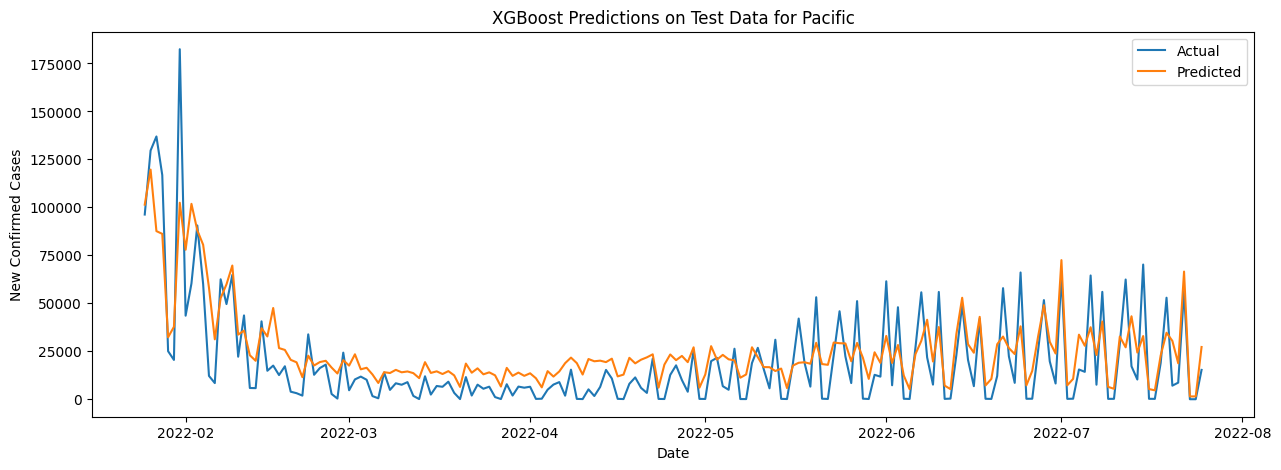


Training model for South Atlantic...
Model Params: n_estimators=500, learning_rate=0.1, max_depth=None, early_stopping_rounds=10
MAE: 1258.26
MSE: 8640241.64
RMSE: 2939.43
MASE: 0.46


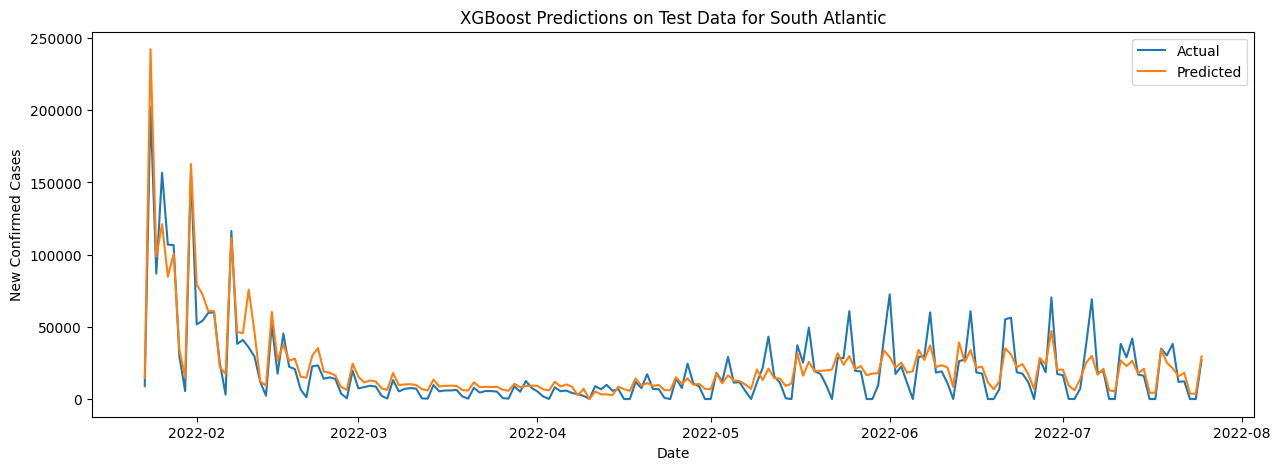


Training model for West North Central...
Model Params: n_estimators=500, learning_rate=0.25, max_depth=None, early_stopping_rounds=10
MAE: 608.6
MSE: 2668649.81
RMSE: 1633.6
MASE: 0.61


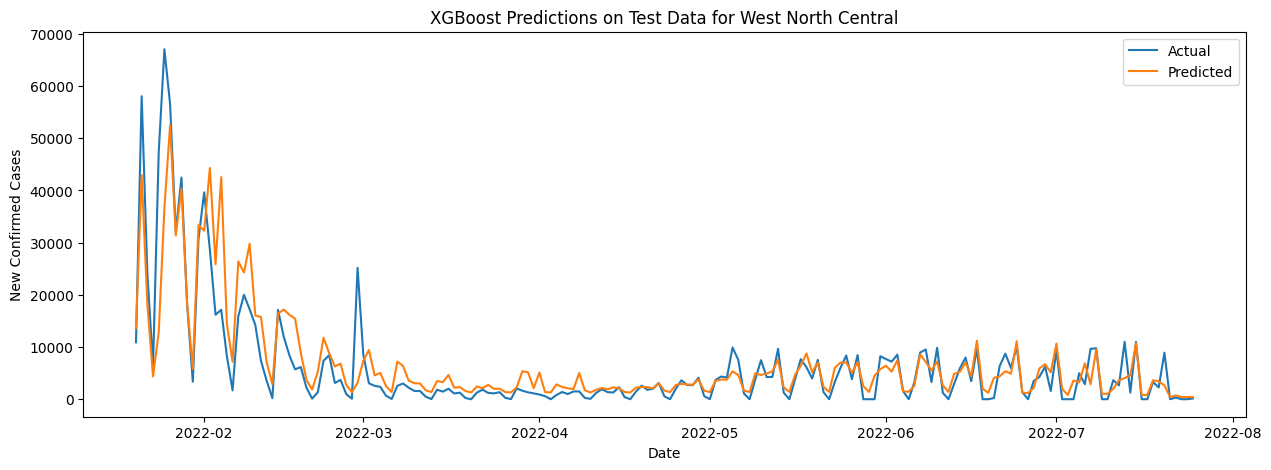


Training model for West South Central...
Model Params: n_estimators=25, learning_rate=0.5, max_depth=4, early_stopping_rounds=10
MAE: 1481.52
MSE: 8040658.77
RMSE: 2835.61
MASE: 0.36


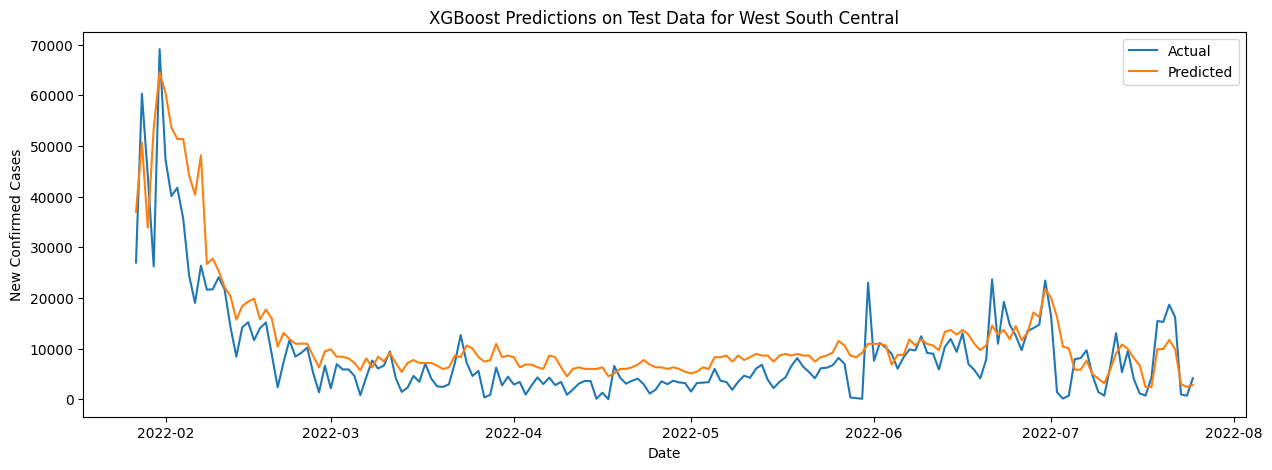


--- 3.03 seconds ---


In [52]:
start_time = time.time()
for df in datasets:
    region = df["region"].iloc[0]
    params = parameters[region]
    final_model(df, params, plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")